# Определение возраста покупателей

Нам предоставлен набор данных - фотографии людей и их возраст.
Задача - обучить нейросеть определять возраст.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

display(data.shape)

Found 7591 validated image filenames.


(7591, 2)

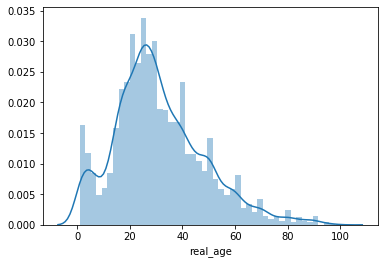

In [3]:
sns_plot = sns.distplot(data['real_age'])
fig = sns_plot.get_figure()

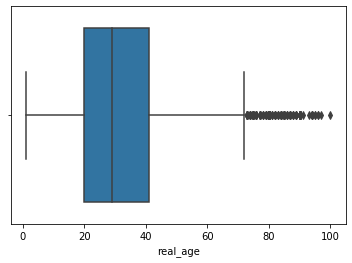

In [4]:
sns_plot = sns.boxplot(data['real_age'])
fig = sns_plot.get_figure()

In [5]:
display(data['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [6]:
age_cnt = data['real_age'].value_counts().reset_index()
age_cnt = age_cnt.rename(columns={'index':'age', 'real_age':'cnt'}).sort_values(by='age')
display(age_cnt.head())

,age,cnt
18,1,149
34,2,88
64,3,25
29,4,101
36,5,87


In [7]:
age_cnt['lag_1_cnt'] = age_cnt['cnt'].shift(1, fill_value=88) #88 как кол-во с возрастом 2
age_cnt['diff'] = age_cnt['cnt']-age_cnt['lag_1_cnt']
display(age_cnt.query('diff>=18').sort_values(by='diff', ascending=False).head(10))

,age,cnt,lag_1_cnt,diff
0,30,317,164,153
1,25,315,211,104
17,50,156,74,82
29,4,101,25,76
8,16,193,128,65
18,1,149,88,61
13,40,167,107,60
25,14,125,79,46
12,32,174,129,45
10,22,179,143,36


Данные по возрасту выглядят адекватно. На гистограмме заметны "выборсы" с периодичностью раз в ~10 лет. Можно предположить, что при разметке данных неизвестный возраст округляли. К сожалению, сейчас определить какие значения дозаполнили, поэтому будем работать с тем что есть.

In [8]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

train_datagen_flow = train_datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    seed=12345)

features, target = next(train_datagen_flow)

Found 5694 images belonging to 1 classes.
Found 1897 images belonging to 1 classes.


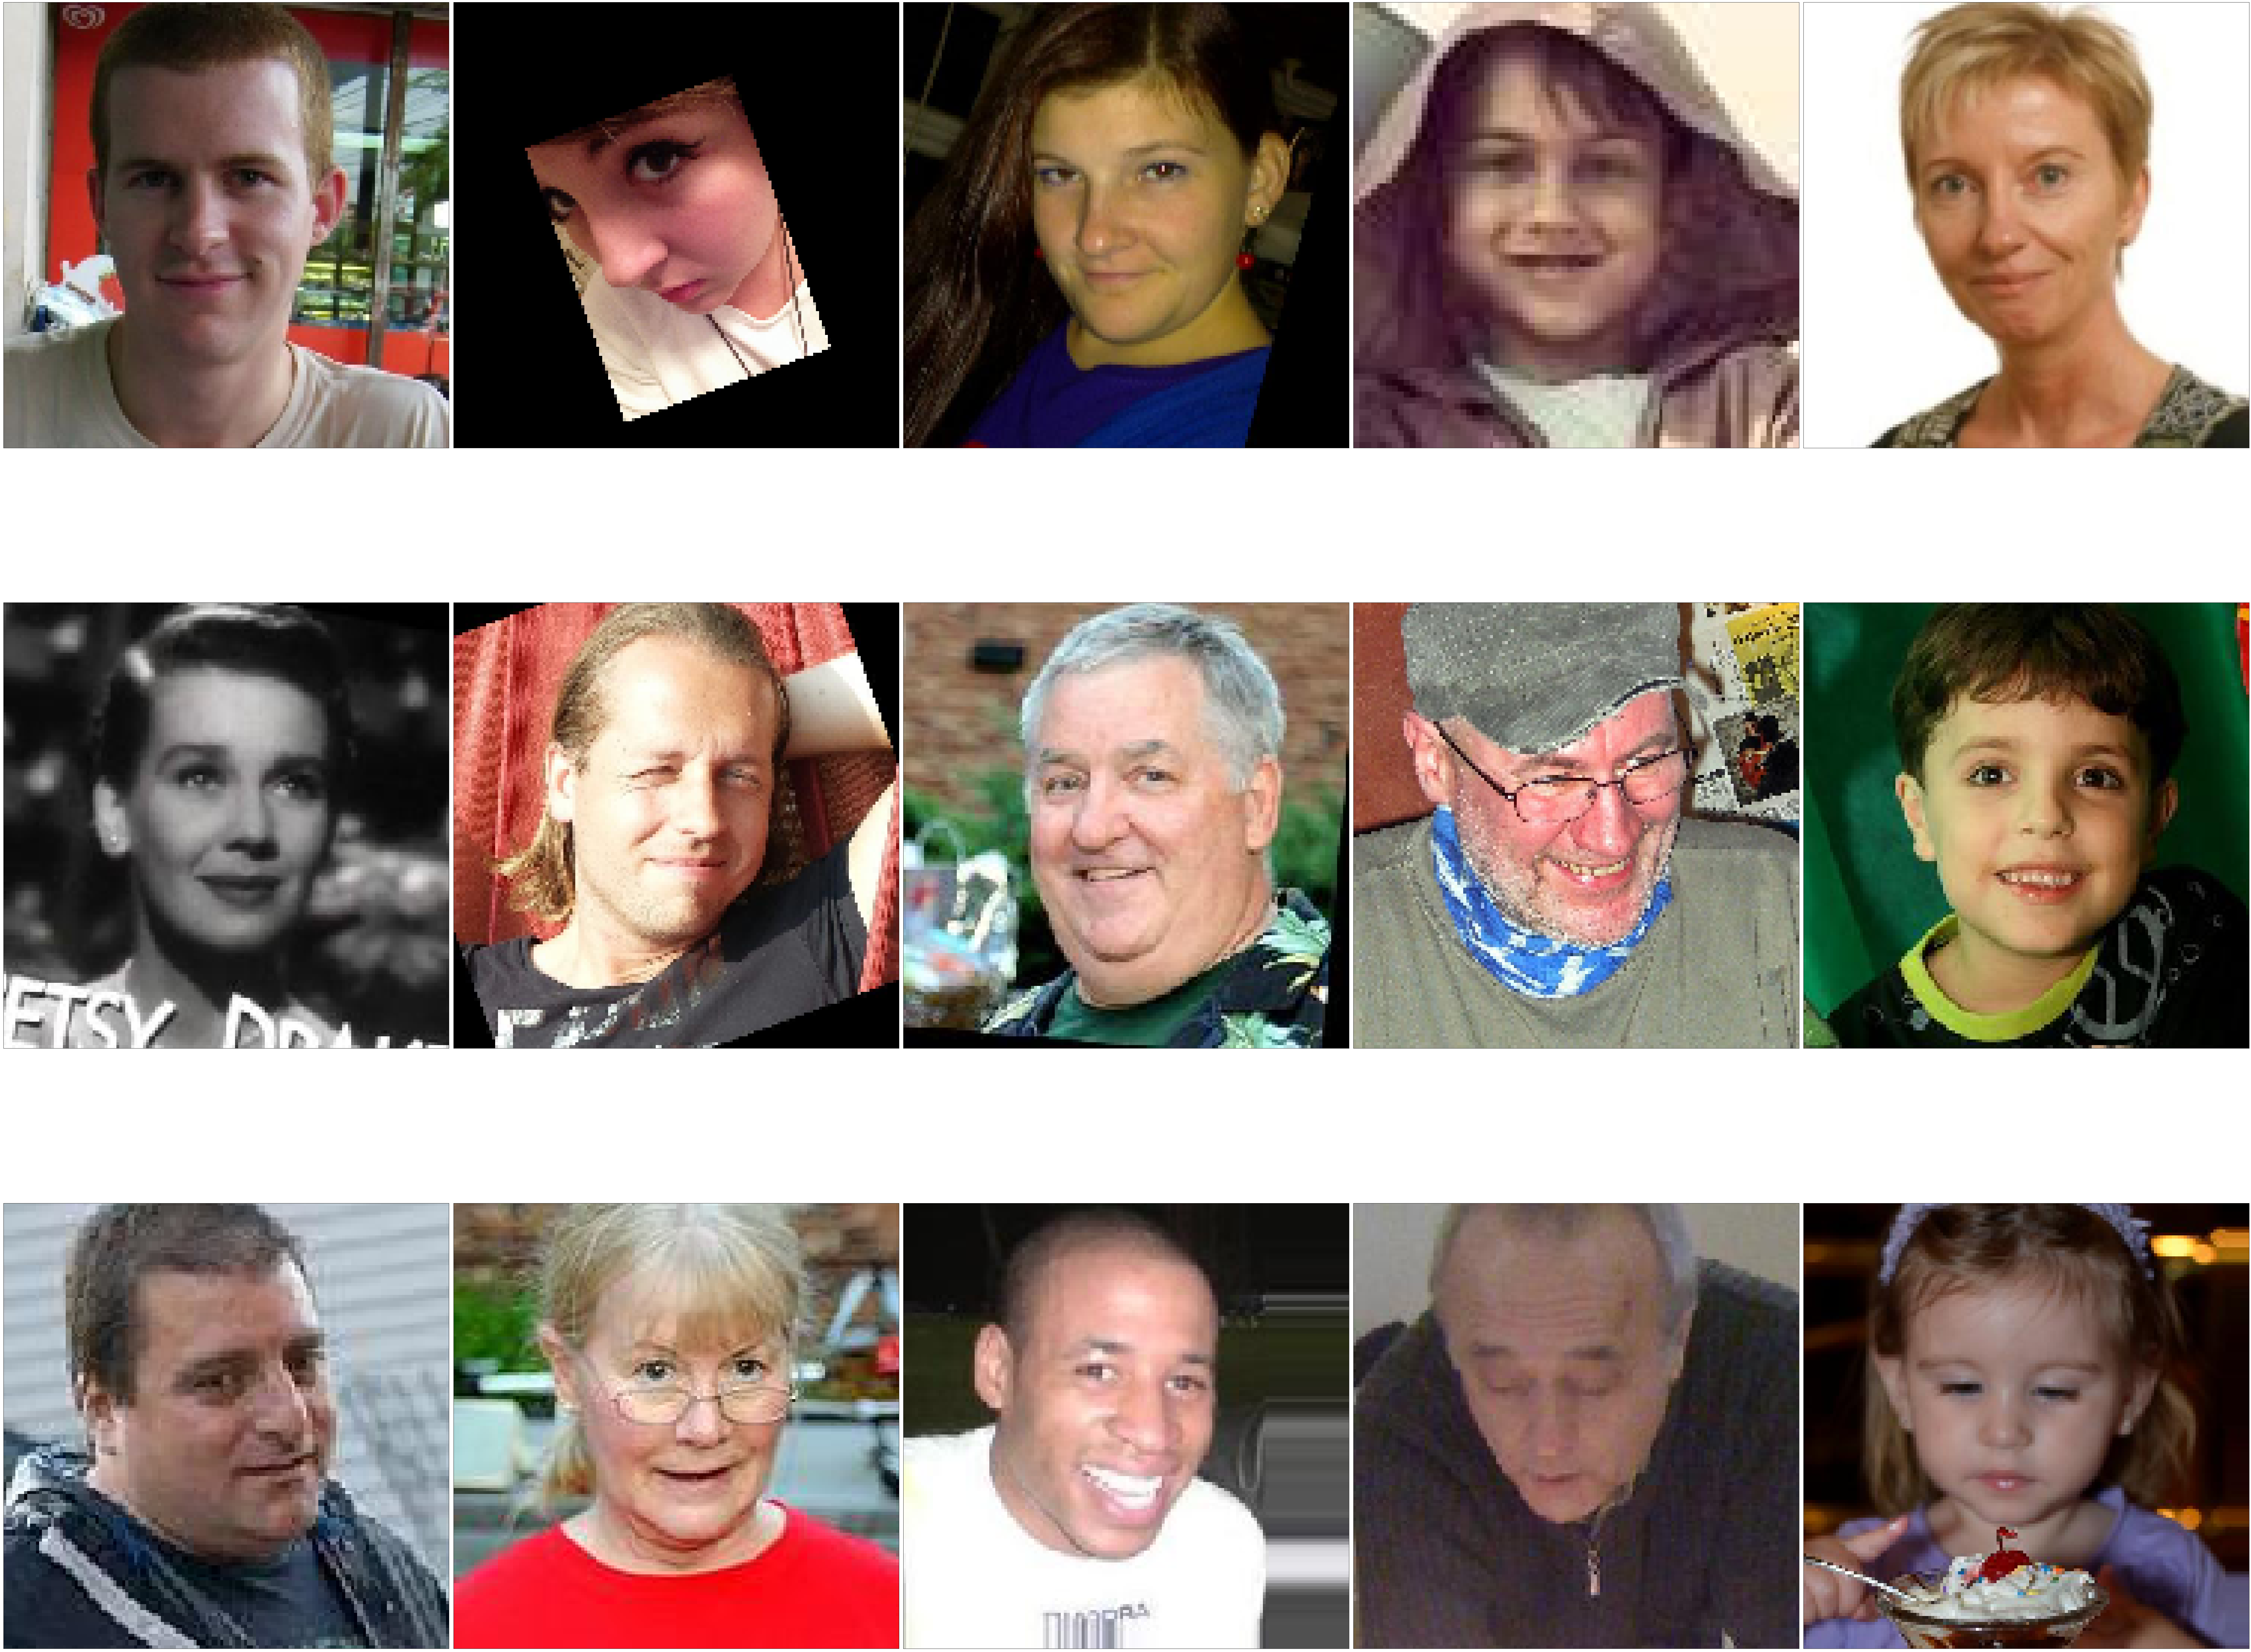

In [10]:
fig = plt.figure(figsize=(100,100))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- Данные по возрасту выглядят адекватно. На гистограмме заметны "выборсы" с периодичностью раз в ~10 лет. Можно предположить, что при разметке данных неизвестный возраст округляли. К сожалению, сейчас определить какие значения дозаполнили, поэтому будем работать с тем что есть
- Выборки из 7591 вполне достаточно, чтобы обучить нейросеть. Разбили на трейн и тест 75/25%.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, AveragePooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, horizontal_flip=True)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='training',
            class_mode='raw',
            seed=12345)

    return train_gen_flow


def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            subset='validation',
            class_mode='raw',
            seed=12345)

    return test_gen_flow


def create_model(input_shape):
    resnet = ResNet50(input_shape=input_shape,
                      weights='imagenet',
                      include_top=False)
    model = Sequential()
    model.add(resnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data,
                batch_size=None,
                epochs=10,
                steps_per_epoch=None,
                validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True, verbose=2)

    return model

```

```

# < скопируйте результат вывода на экран сюда >
Train for 178 steps, validate for 60 steps
Epoch 1/10
2021-12-01 13:30:19.245788: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-01 13:30:19.530880: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 257.4729 - mae: 11.5146 - val_loss: 633.9629 - val_mae: 20.1968
Epoch 2/10
178/178 - 37s - loss: 78.1003 - mae: 6.6391 - val_loss: 621.9774 - val_mae: 19.8115
Epoch 3/10
178/178 - 37s - loss: 53.0255 - mae: 5.5249 - val_loss: 299.5340 - val_mae: 12.7360
Epoch 4/10
178/178 - 37s - loss: 37.5458 - mae: 4.6720 - val_loss: 107.1576 - val_mae: 7.8040
Epoch 5/10
178/178 - 37s - loss: 28.2299 - mae: 4.0573 - val_loss: 82.1156 - val_mae: 6.7298
Epoch 6/10
178/178 - 37s - loss: 19.9424 - mae: 3.4244 - val_loss: 69.2657 - val_mae: 6.2102
Epoch 7/10
178/178 - 37s - loss: 16.7327 - mae: 3.1444 - val_loss: 86.3207 - val_mae: 6.9690
Epoch 8/10
178/178 - 37s - loss: 13.8160 - mae: 2.8441 - val_loss: 68.9627 - val_mae: 6.0961
Epoch 9/10
178/178 - 37s - loss: 10.6582 - mae: 2.4767 - val_loss: 66.2310 - val_mae: 6.1431
Epoch 10/10
178/178 - 38s - loss: 10.0468 - mae: 2.3788 - val_loss: 74.1497 - val_mae: 6.5710
# < длинные строки со скачиванием модели можно удалить >

```

## Анализ обученной модели

Для улучшения нейросети мы сделали аугментацию при обучении (отразили по горизонтали), что привело к хорошему показателю метрики MAE на тесте. Наилучший результат MAE теста на 8 эпохе = 6.09.